# Neural machine translation with Seq2Seq
## Install dependences

In [ ]:
# install the latest kashgari
!pip uninstall -y kashgari
!pip install git+https://github.com/BrikerMan/Kashgari@v2-dev
!pip install hanziconv
!pip install segtok

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/ This dataset contains language translation pairs in the format:

```
I'm on Tom's side.	我站在湯姆一邊。	CC-BY 2.0 (France) Attribution: tatoeba.org #2549046 (CK) & #6065739 (verdastelo9604)
```

There are a variety of languages available, but we'll use the English-Chinese dataset. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.

In [ ]:
# Setup data path
DATA_PATH = 'cmn.txt'

In [7]:
import numpy as np
import pandas as pd
from hanziconv import HanziConv
from segtok.tokenizer import word_tokenizer

import tensorflow as tf

df = pd.read_csv(DATA_PATH, header=None, sep='\t')

df.columns = ['en', 'cn', 'cc']

df['cn'] = df['cn'].apply(lambda x: HanziConv.toSimplified(x))
df['en_cutted'] = df['en'].apply(lambda x: word_tokenizer(x.lower()))
df['cn_cutted'] = df['cn'].apply(lambda x: list(x))
df.head()

,en,cn,cc,en_cutted,cn_cutted
0,Hi.,嗨。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,"[hi, .]","[嗨, 。]"
1,Hi.,你好。,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,"[hi, .]","[你, 好, 。]"
2,Run.,你用跑的。,CC-BY 2.0 (France) Attribution: tatoeba.org #4...,"[run, .]","[你, 用, 跑, 的, 。]"
3,Wait!,等等！,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,"[wait, !]","[等, 等, ！]"
4,Wait!,等一下！,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,"[wait, !]","[等, 一, 下, ！]"


In [8]:
input_datas = df['en_cutted'].values
target_datas = df['cn_cutted'].values

print(f'Input sentence samples  : {input_datas[:3]}')
print(f'Output sentence samples : {target_datas[:3]}')
print(f'Total sentence count    : {len(input_datas)}')

Input sentence samples  : [list(['hi', '.']) list(['hi', '.']) list(['run', '.'])]
Output sentence samples : [list(['嗨', '。']) list(['你', '好', '。']) list(['你', '用', '跑', '的', '。'])]
Total sentence count    : 8309


## Build model and fit

In [9]:
from kashgari.tasks.seq2seq.model import Seq2Seq
model = Seq2Seq()

Seq2Seq API is experimental. It may be changed in the future without notice.


In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
        self.sample_count = 5

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        import random
        samples = random.sample(list(input_datas), self.sample_count)
        translates, _ = self.model.predict(samples)
        print()
        for index in range(len(samples)):
            print(f"English: {' '.join(samples[index])}")
            print(f"Chinese: {''.join(translates[index])}")
            print('------------------------------')

In [ ]:
his_callback = CustomCallback(model)
history = model.fit(input_datas,
                    target_datas,
                    callbacks=[his_callback],
                    epochs=50,
                    batch_size=64)

In [14]:
import random
x = random.sample(list(input_datas), 5)
transalte, attention = model.predict(x, debug_info=True)

for i in range(len(x)):
    print(f"{' '.join(x[i]):<40} -> {''.join(transalte[i])}")


---------------------------
input sentence  : i'm glad i was there .
input idx       : [  2  19 379   5  27  70   4   3   0]
output idx      : [5, 23, 104, 175, 5, 18, 28, 37, 4, 3]
output sentence : 我 很 高 兴 我 在 那 里 。

---------------------------
input sentence  : that young lady is a nurse .
input idx       : [   2   28  436  977    8    9 1366    4    3]
output idx      : [17, 21, 166, 290, 239, 114, 11, 518, 228, 4, 3]
output sentence : 这 个 年 轻 女 孩 是 护 士 。

---------------------------
input sentence  : give me my beer .
input idx       : [  2 107  15  17 495   4   3   0   0]
output idx      : [71, 5, 8, 594, 257, 44, 5, 4, 3]
output sentence : 把 我 的 啤 酒 给 我 。

---------------------------
input sentence  : do you know where he lives ?
input idx       : [  2  16   7  49  81  13 422   6   3]
output idx      : [6, 64, 59, 10, 176, 18, 19, 9, 3]
output sentence : 你 知 道 他 住 在 吗 ？

---------------------------
input sentence  : it rained hard last night .
input idx       : [  2  14 987 170

## Visualize

In order to render Chinese, need to install Chinese characters (on Ubuntu / Colab).

In [15]:
# Download the target font
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

--2020-05-21 05:25:53--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  5.68MB/s    in 1.8s    

2020-05-21 05:25:56 (5.68 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [ ]:
# function for plotting the attention weights
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

font_name = 'SIMHEI'
plt.rcParams['font.family'] = font_name #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
zhfont = font_manager.FontProperties(fname='/usr/share/fonts/truetype/SimHei.ttf')

# 如果绘制图表不清晰，可以设置高 dpi 来提高图表清晰度
plt.rcParams['figure.dpi'] = 120

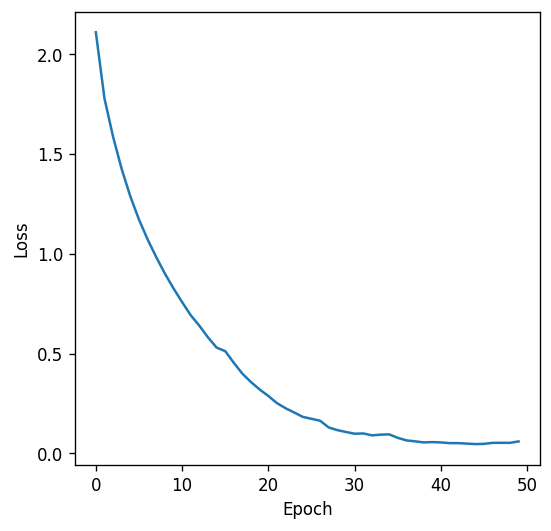

In [17]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=zhfont)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  predicted_sentences, attention_weights = model.predict([sentence])
  sentence = ['<s>'] + sentence + ['</s>']
  result = predicted_sentences[0] + ['</s>']
  attention_plot = attention_weights[0]

  print('Input:', ' '.join(sentence))
  print('Predicted translation: {}'.format(' '.join(result)))

  attention_plot = attention_plot[:len(result), 1:len(sentence)+1]
  plot_attention(attention_plot, sentence, result)

Input: <s> she isn't afraid of death . </s>
Predicted translation: 她 不 怕 死 。 </s>


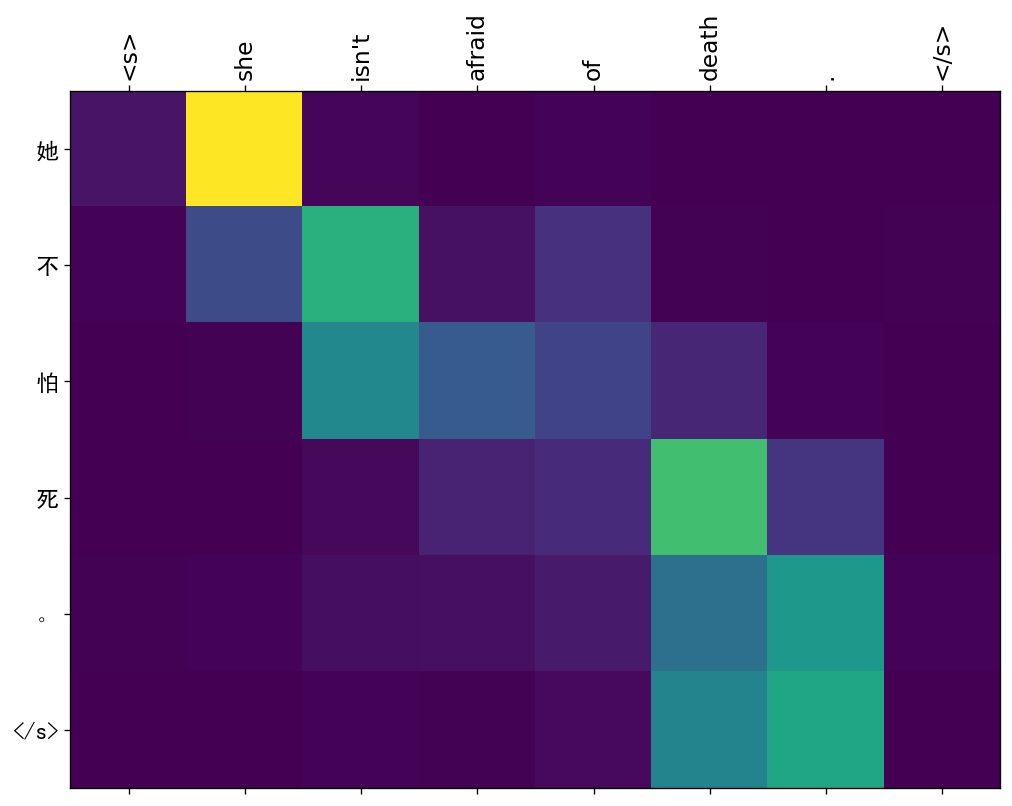

In [26]:
translate("she isn't afraid of death .".split(' '))

Input: <s> that young lady is a nurse . </s>
Predicted translation: 这 个 年 轻 女 孩 是 护 士 。 </s>


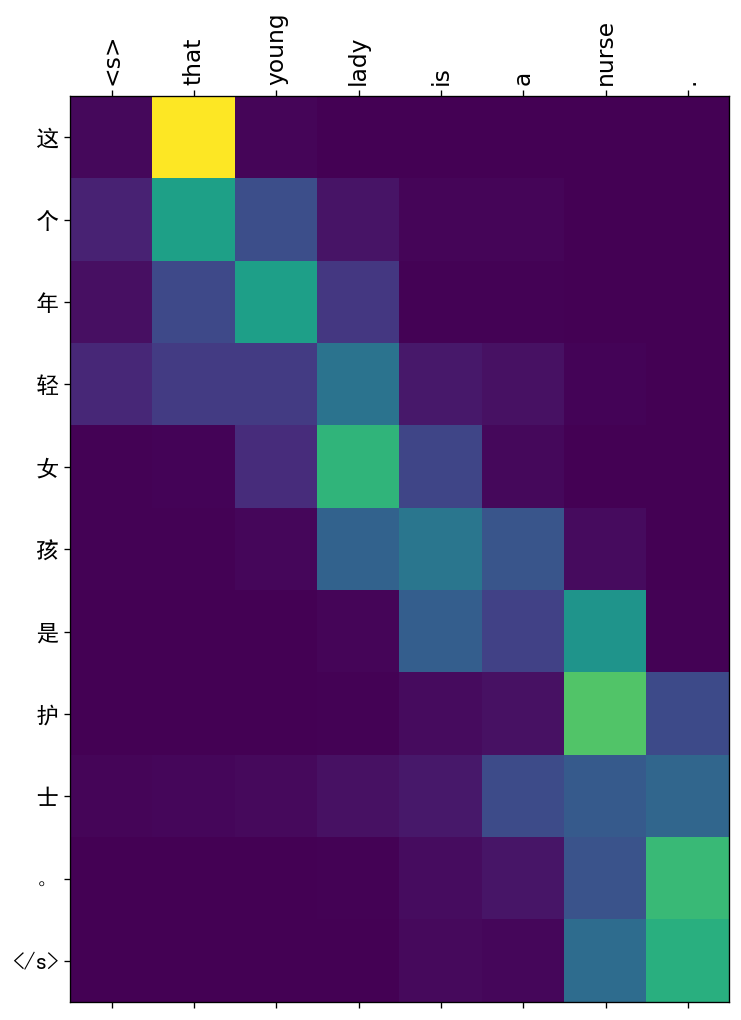

In [27]:
translate("that young lady is a nurse .".split(' '))

Input: <s> don't bug me . </s>
Predicted translation: 别 来 烦 我 。 </s>


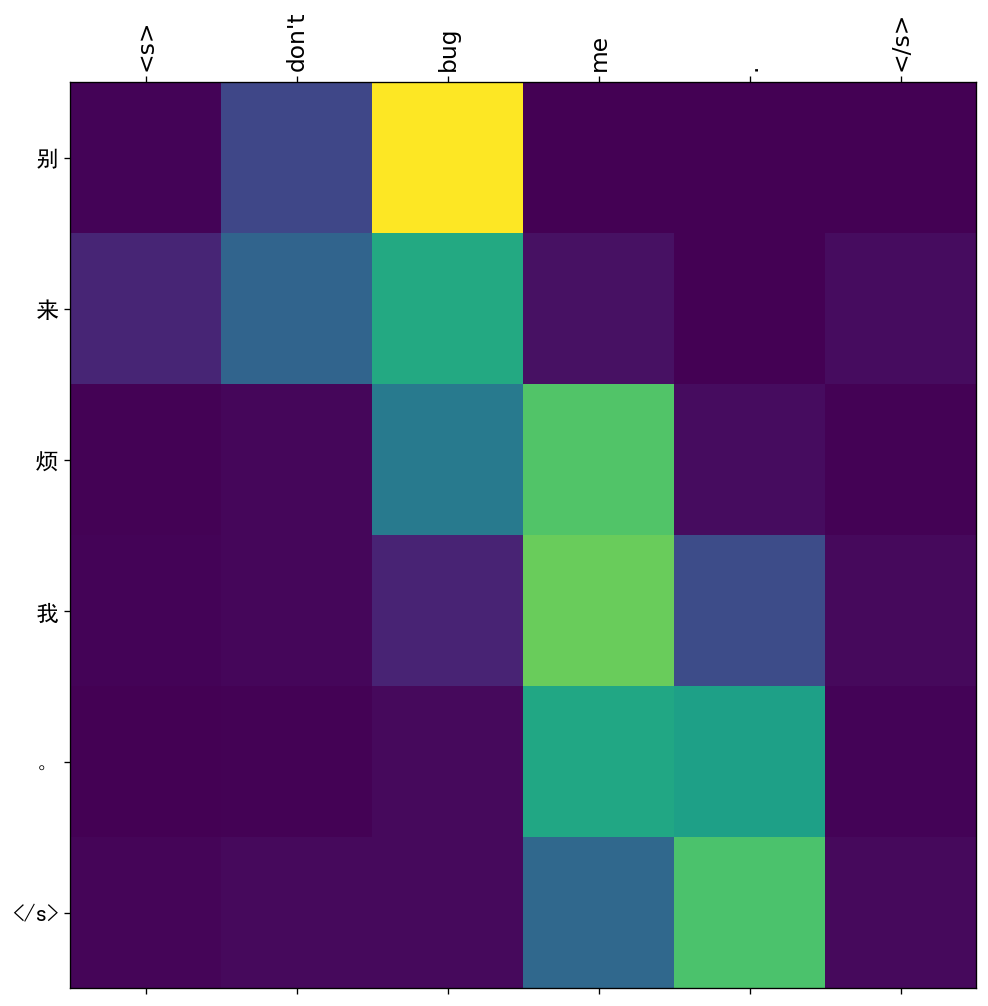

Input: <s> tom never wanted to try it . </s>
Predicted translation: 汤 姆 从 不 想 试 试 。 </s>


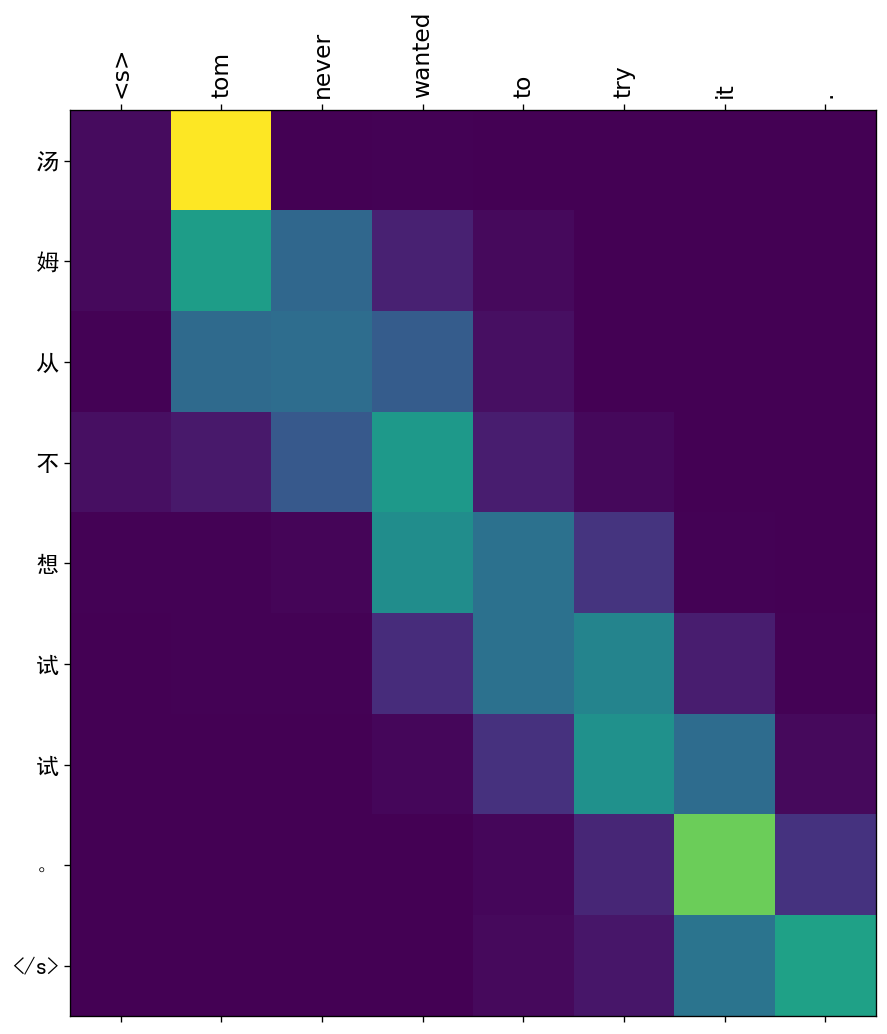

Input: <s> what's wrong , honey ? </s>
Predicted translation: 出 什 么 事 了 ， 宝 贝 ？ </s>


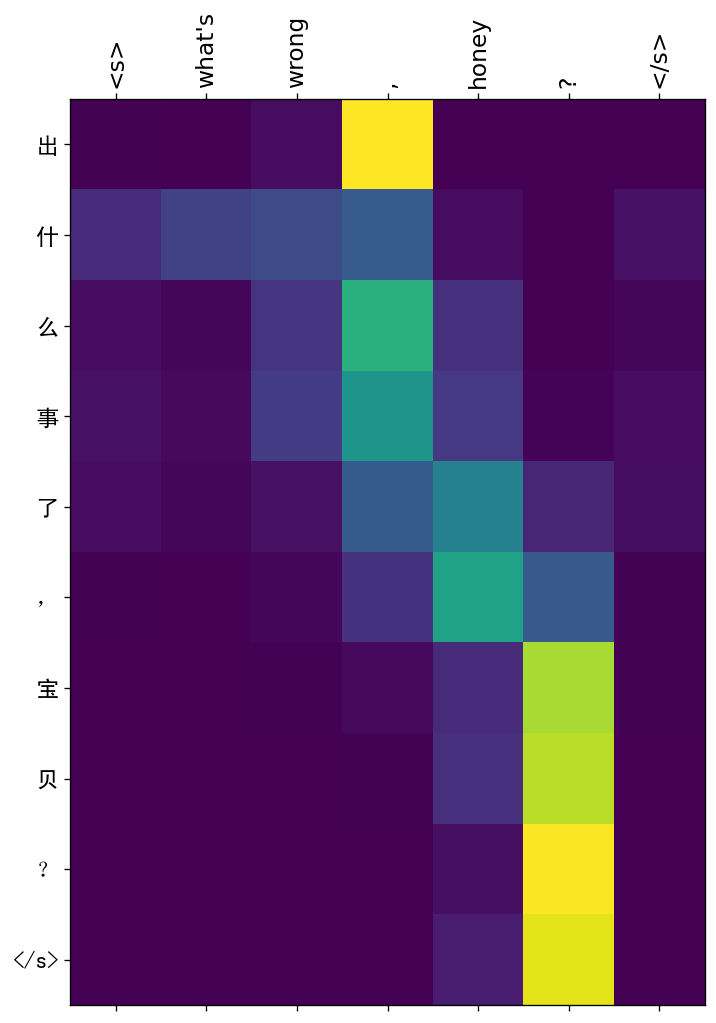

Input: <s> i don't see much of him . </s>
Predicted translation: 我 不 常 见 到 他 。 </s>


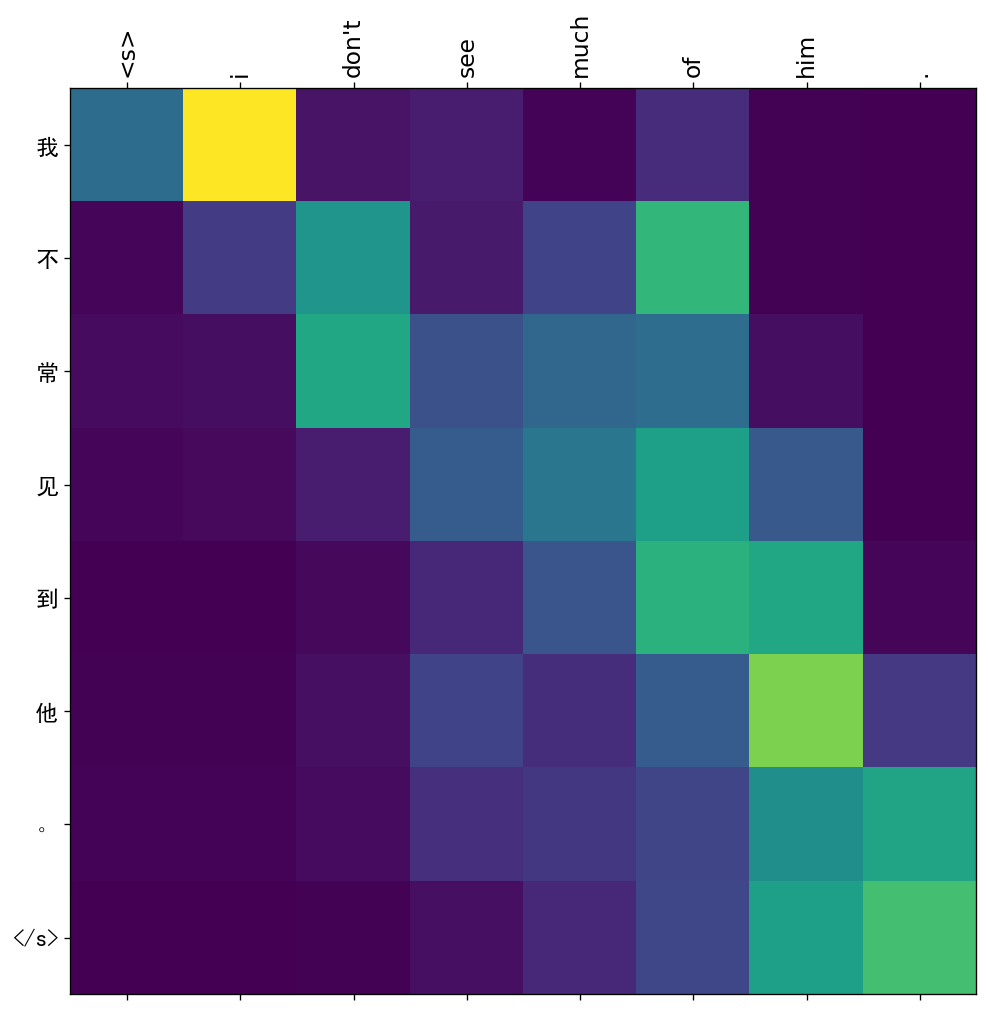

Input: <s> i bathe every day . </s>
Predicted translation: 我 每 天 都 洗 澡 。 </s>


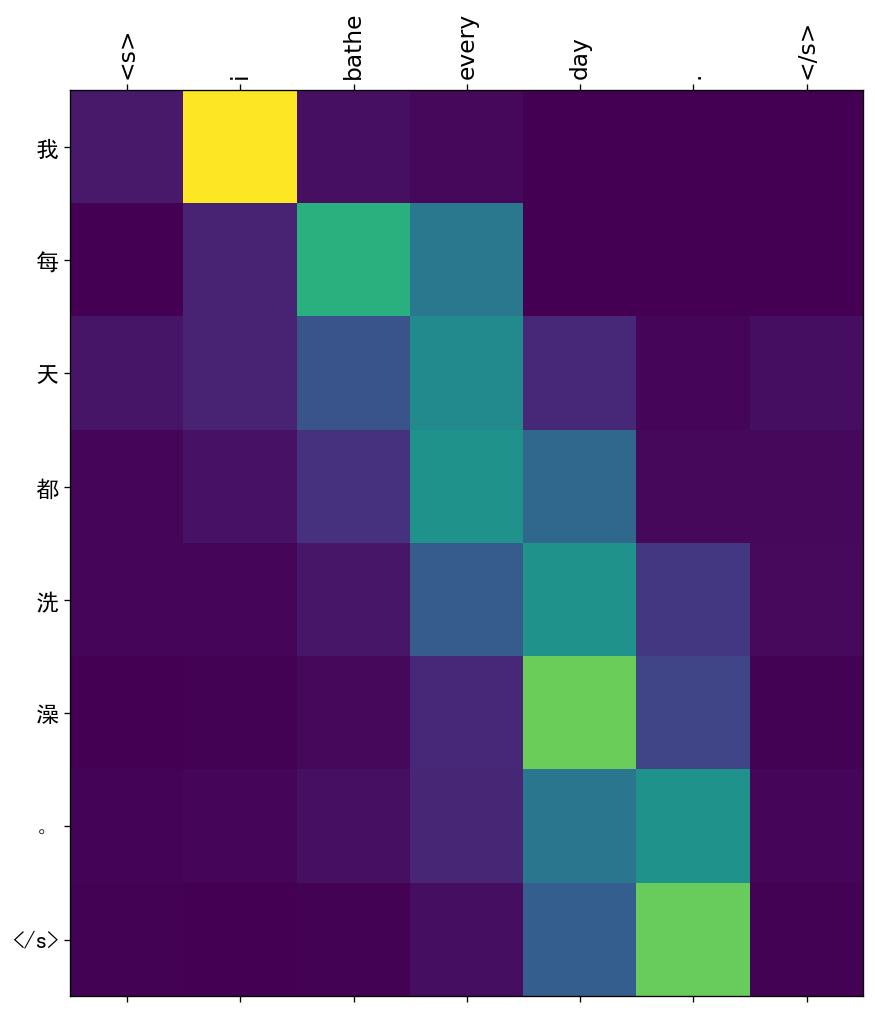

In [30]:
import random

for sentence in random.sample(list(input_datas), 5):
    translate(sentence)